## TimeSOM

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def dtw_distance(s, t, w):
    """https://en.wikipedia.org/wiki/Dynamic_time_warping"""
    n = len(s)
    m = len(t)
    
    # Step 1: Adjust the window size to handle cases where |n - m| is large
    w = max(w, abs(n - m))
    
    # Step 2: Initialize the DTW matrix with infinity
    DTW = np.full((n + 1, m + 1), np.inf)
    DTW[0, 0] = 0
    
    # Step 3: Fill the boundaries of the DTW matrix
    for i in range(1, n + 1):
        for j in range(max(1, i - w), min(m, i + w) + 1):
            DTW[i, j] = 0

    # Step 4: Compute the DTW distance
    for i in range(1, n + 1):
        for j in range(max(1, i - w), min(m, i + w) + 1):
            cost = abs(s[i - 1] - t[j - 1])  # Distance function, e.g., absolute difference
            DTW[i, j] = cost + min(
                DTW[i - 1, j],    # Insertion
                DTW[i, j - 1],    # Deletion
                DTW[i - 1, j - 1] # Match
            )

    # Return the DTW distance between the two series
    return DTW[n, m]

# Example usage
s = np.array([1, 2, 3, 4, 5])
t = np.array([2, 3, 4, 5, 6])
window_size = 5

distance = dtw_distance(s, t, window_size)
print("DTW Distance:", distance)

DTW Distance: 2.0


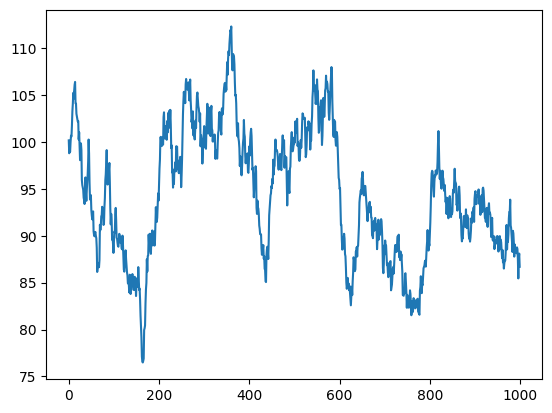

In [228]:
def brownian_motion(
    n: int,
    mu: float,
    sigma: float,
    initial_value: float = 1.,
    geometric: bool = True,
    seed: int = None
) -> np.ndarray:
    """
    Simulates Brownian Motion or Geometric Brownian Motion (GBM).

    Parameters
    ----------
    n : int
        Number of timesteps.
    mu : float
        Constant mean (drift rate) for GBM.
    sigma : float
        Constant standard deviation (volatility).
    initial_value : float, optional
        Initial value of the motion (default is 1.0).
    geometric : bool, optional
        If True, simulate Geometric Brownian Motion; otherwise, simulate standard Brownian Motion (default is True).
    seed : int, optional
        Seed for random number generation to ensure reproducibility (default is 42).

    Returns
    -------
    np.ndarray
        array of shape (n,).
    """
    dt = 1  # frequency
    rng = np.random.default_rng(seed=seed)
    t = np.linspace(0, 1, n)
    random_steps = rng.standard_normal(size=n)
    motion = np.cumsum(random_steps) * np.sqrt(dt)  # Brownian motion
    if geometric:
        motion = (mu - 0.5 * sigma**2) * t + sigma * motion
        motion = initial_value * np.exp(motion)  # Geometric Brownian motion
    else:
        motion = initial_value + motion
    return motion


data = brownian_motion(n=1000, mu=0.0005, sigma=0.012, geometric=True, initial_value=100., seed=4342)
plt.plot(data)


In [229]:
from numpy.lib.stride_tricks import sliding_window_view

def window(a: np.ndarray, shape: tuple[int]):
    return sliding_window_view(a, window_shape=shape)

def window1d(a: np.ndarray, size: int):
    return window(a, (size,))

windowed_data = window1d(data, 30)
# all sequences be on the same scale so we can properly compare their shape
windowed_data = windowed_data - np.expand_dims(windowed_data[:,0], axis=1)
windowed_data.shape

(971, 30)

In [234]:
class TimeSOM:
    def __init__(self, grid_size, time_series_length, learning_rate, max_iterations):
        self.grid_size = grid_size  # Size of the SOM grid (e.g., 10x10)
        self.shape = (grid_size, grid_size)
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.time_series_length = time_series_length

        # Initialize the weight vectors for each node randomly
        self.weights = np.random.rand(grid_size, grid_size, time_series_length)

    def train(self, data):
        for iteration in range(self.max_iterations):
            # Step 1: Select a random input time series
            input_series = data[np.random.randint(len(data))]

            # Step 2: Compute DTW distance between the input series and each node's weight vector
            dtw_distances = np.zeros((self.grid_size, self.grid_size))
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    dtw_distances[i, j] = dtw_distance(input_series, self.weights[i, j], w=5)  # Adjust w as needed

            # Step 3: Find the Best Matching Unit (BMU)
            bmu_index = np.unravel_index(np.argmin(dtw_distances), dtw_distances.shape)
            bmu_i, bmu_j = bmu_index

            # Step 4: Update the weight vectors of the BMU and its neighbors
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    # Calculate the neighborhood influence
                    distance_to_bmu = np.linalg.norm(np.array([i, j]) - np.array([bmu_i, bmu_j]))
                    neighborhood_influence = np.exp(-distance_to_bmu**2 / (2 * (self.learning_rate**2)))

                    # Update the weight vector
                    self.weights[i, j] += neighborhood_influence * self.learning_rate * (input_series - self.weights[i, j])

            # Decrease the learning rate over time
            # self.learning_rate *= (1 - iteration / self.max_iterations)
            self.learning_rate *= np.exp(-iteration / self.max_iterations)
            if (iteration + 1) % 50 == 0:
                print(f"Completed Iteration {iteration + 1} / {self.max_iterations}")

    def get_weights(self):
        return self.weights


som = TimeSOM(grid_size=5, time_series_length=30, learning_rate=0.5, max_iterations=500)
som.train(windowed_data)


Completed Iteration 50 / 500
Completed Iteration 100 / 500
Completed Iteration 150 / 500
Completed Iteration 200 / 500
Completed Iteration 250 / 500
Completed Iteration 300 / 500
Completed Iteration 350 / 500
Completed Iteration 400 / 500
Completed Iteration 450 / 500
Completed Iteration 500 / 500


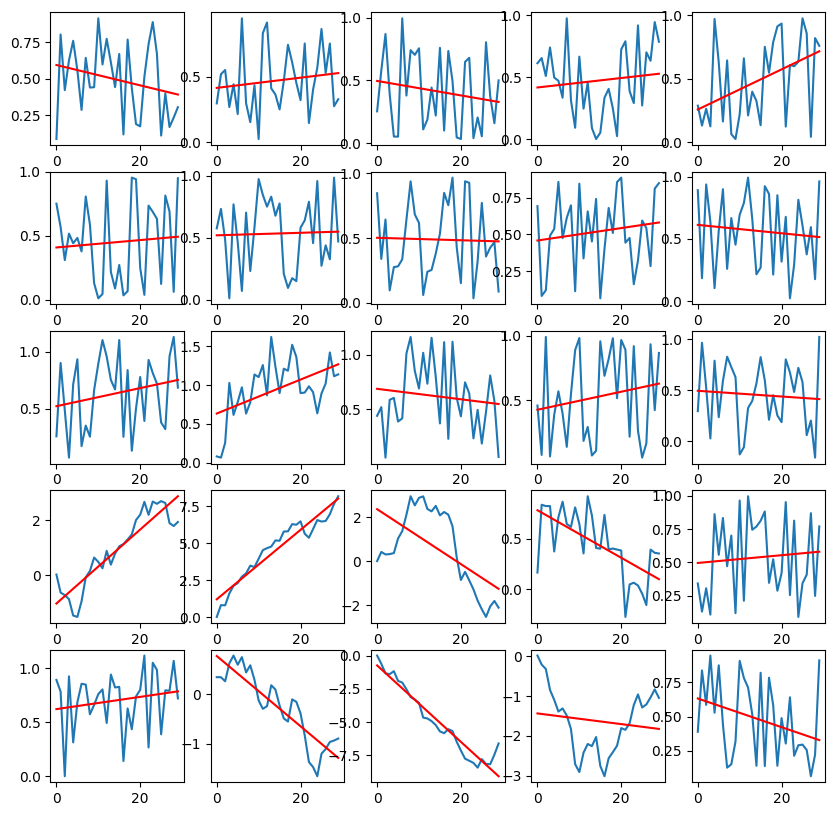

In [236]:
def linreg(y: np.ndarray):
    assert y.ndim == 1
    x = np.arange(y.size)
    m, b = np.polyfit(x, y, 1)
    return m * x + b
    
fig, axes = plt.subplots(som.shape[0], som.shape[1], figsize=(10, 10))
for i in range(som.shape[0]):
    for j in range(som.shape[1]):
        axes[i, j].plot(som.weights[i, j])
        axes[i, j].plot(linreg(som.weights[i, j]), c="red")
plt.show()
